In [ ]:
import kagglehub
path = kagglehub.dataset_download("abhi8923shriv/sentiment-analysis-dataset")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'sentiment-analysis-dataset' dataset.
Path to dataset files: /kaggle/input/sentiment-analysis-dataset


In [ ]:
pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 68.0 MB/s eta 0:00:00


complete preprocessing and lda is combined into a single cell

In [ ]:
import kagglehub
import os
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.utils import check_array
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
path = kagglehub.dataset_download("abhi8923shriv/sentiment-analysis-dataset")
dataset_path = path
print("Path to dataset files:", dataset_path)
print(os.listdir(dataset_path))
file_path = os.path.join(dataset_path, 'train.csv')
df = pd.read_csv(file_path, encoding='latin-1')
df.dropna(subset=['text', 'selected_text'], inplace=True)
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt', quiet=True)
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords', quiet=True)
try:
    nltk.data.find('wordnet')
except LookupError:
    nltk.download('wordnet', quiet=True)
try:
    nltk.data.find('taggers/averaged_perceptron_tagger')
except LookupError:
    nltk.download('averaged_perceptron_tagger', quiet=True)
try:
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    nltk.download('punkt_tab', quiet=True)


lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    words = text.split()
    words = [word for word in words if word not in stop_words]
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

df['cleaned_text'] = df['text'].apply(clean_text)
df['tokens'] = df['cleaned_text'].apply(word_tokenize)
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_text'])
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, df['sentiment'], test_size=0.2, random_state=42)

class LDAModelWithMetrics(LatentDirichletAllocation):
    def __init__(self, n_components=10, *, doc_topic_prior=None, topic_word_prior=None,
                 learning_method='batch', learning_decay=0.7, learning_offset=10.0,
                 max_iter=10, batch_size=128, evaluate_every=-1, total_samples=1000000.0,
                 perp_tol=0.1, mean_change_tol=0.001, max_doc_update_iter=100,
                 n_jobs=None, verbose=0, random_state=None):
        super().__init__(n_components=n_components, doc_topic_prior=doc_topic_prior,
                         topic_word_prior=topic_word_prior, learning_method=learning_method,
                         learning_decay=learning_decay, learning_offset=learning_offset,
                         max_iter=max_iter, batch_size=batch_size, evaluate_every=evaluate_every,
                         total_samples=total_samples, perp_tol=perp_tol, mean_change_tol=mean_change_tol,
                         max_doc_update_iter=max_doc_update_iter, n_jobs=n_jobs, verbose=verbose,
                         random_state=random_state)
        self.perplexity_scores = []
        self.log_likelihood_scores = []
        self.topic_coherence_scores = []
        self._actual_max_iter = max_iter
        self.max_iter = 1

    def calculate_coherence(self, tokenized_texts, dictionary, coherence_measure='c_v', topn=10):
        if not hasattr(self, 'components_'):
            return None
        feature_names = tfidf_vectorizer.get_feature_names_out()
        topics = []
        for topic in self.components_:
            top_words_idx = topic.argsort()[-topn:][::-1]
            top_words = [feature_names[i] for i in top_words_idx]
            topics.append(top_words)
        coherence_model = CoherenceModel(topics=topics, texts=tokenized_texts,
                                         dictionary=dictionary, coherence=coherence_measure)
        coherence_score = coherence_model.get_coherence()
        return coherence_score


    def fit(self, X, y=None, tokenized_texts=None, dictionary=None):
        X = check_array(X, accept_sparse=['csr', 'csc'])
        n_samples, n_features = X.shape

        if tokenized_texts is None or dictionary is None:
             raise ValueError("tokenized_texts and dictionary must be provided for coherence calculation.")

        for i in range(self._actual_max_iter):
            super().partial_fit(X)

            if hasattr(self, 'components_'):
                perplexity = self.perplexity(X)
                log_likelihood = self.score(X)
                self.perplexity_scores.append(perplexity)
                self.log_likelihood_scores.append(log_likelihood)


                coherence = self.calculate_coherence(tokenized_texts, dictionary)
                self.topic_coherence_scores.append(coherence)

                if self.verbose > 0:
                    print(f"Iteration {i+1}/{self._actual_max_iter}: Perplexity = {perplexity:.2f}, Log Likelihood = {log_likelihood:.2f}, Coherence = {coherence:.4f}")
            else:
                 if self.verbose > 0:
                    print(f"Iteration {i+1}/{self._actual_max_iter}: components_ not yet available for metric calculation.")


        return self
corpus_dictionary = Dictionary(df['tokens'])
lda_with_metrics = LDAModelWithMetrics(n_components=10, max_iter=10, random_state=42, verbose=1)
lda_with_metrics.fit(X_train, tokenized_texts=df['tokens'].tolist(), dictionary=corpus_dictionary)
print("Perplexity scores:", lda_with_metrics.perplexity_scores)
print("Log likelihood scores:", lda_with_metrics.log_likelihood_scores)
print("Topic coherence scores:", lda_with_metrics.topic_coherence_scores)

Using Colab cache for faster access to the 'sentiment-analysis-dataset' dataset.
Path to dataset files: /kaggle/input/sentiment-analysis-dataset
['training.1600000.processed.noemoticon.csv', 'train.csv', 'testdata.manual.2009.06.14.csv', 'test.csv']
Iteration 1/10: Perplexity = 17749.98, Log Likelihood = -489793.89, Coherence = 0.3436
Iteration 2/10: Perplexity = 15863.99, Log Likelihood = -484170.51, Coherence = 0.3337
Iteration 3/10: Perplexity = 15427.63, Log Likelihood = -482774.25, Coherence = 0.3375
Iteration 4/10: Perplexity = 15261.10, Log Likelihood = -482230.97, Coherence = 0.3375
Iteration 5/10: Perplexity = 15183.35, Log Likelihood = -481975.26, Coherence = 0.3429
Iteration 6/10: Perplexity = 15137.95, Log Likelihood = -481825.37, Coherence = 0.3450
Iteration 7/10: Perplexity = 15111.27, Log Likelihood = -481737.06, Coherence = 0.3404
Iteration 8/10: Perplexity = 15095.09, Log Likelihood = -481683.43, Coherence = 0.3432
Iteration 9/10: Perplexity = 15082.74, Log Likelihood 

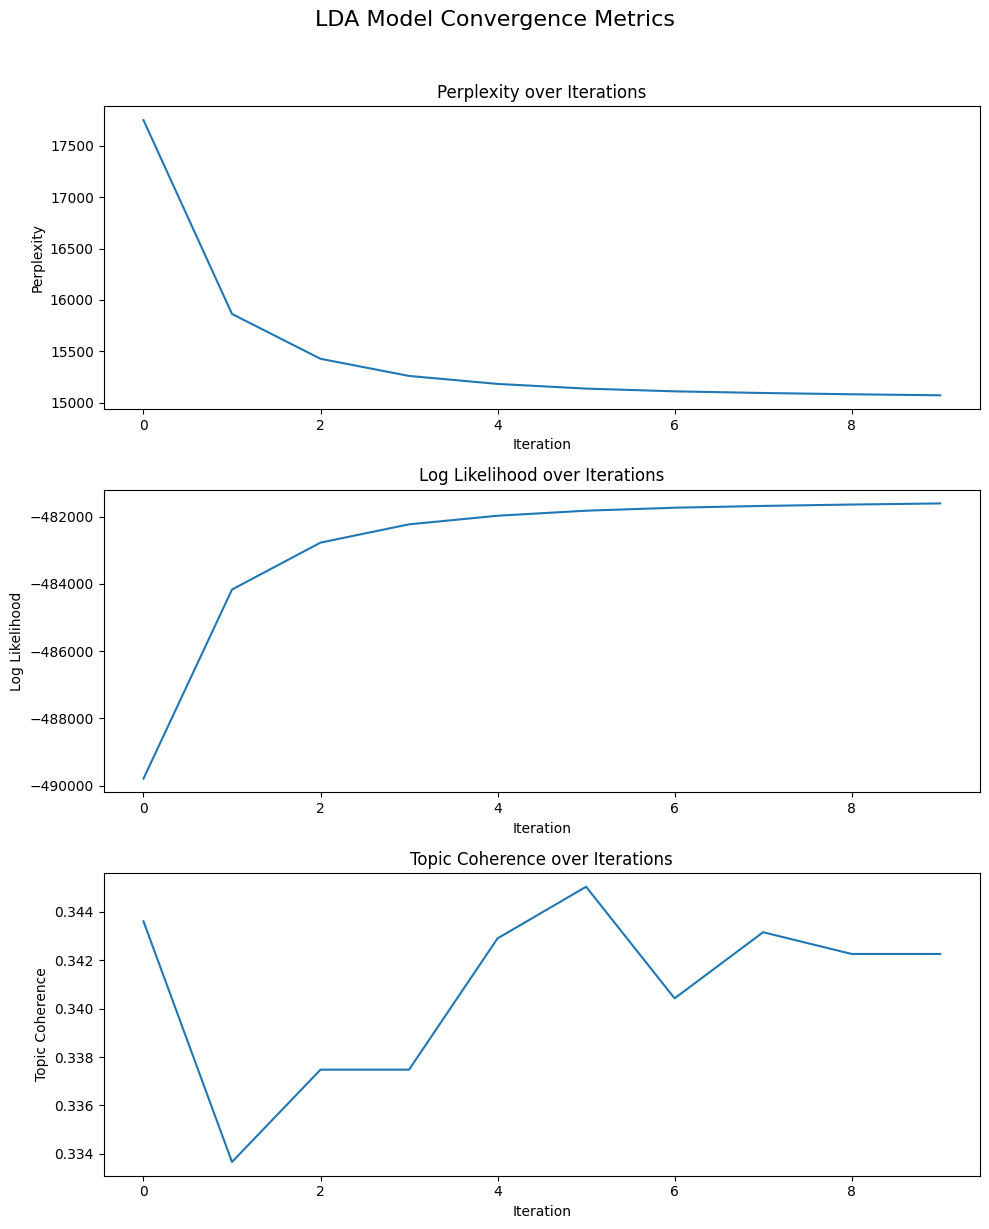

In [ ]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(3, 1, figsize=(10, 12))
axes[0].plot(lda_with_metrics.perplexity_scores)
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Perplexity')
axes[0].set_title('Perplexity over Iterations')
axes[1].plot(lda_with_metrics.log_likelihood_scores)
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Log Likelihood')
axes[1].set_title('Log Likelihood over Iterations')
axes[2].plot(lda_with_metrics.topic_coherence_scores)
axes[2].set_xlabel('Iteration')
axes[2].set_ylabel('Topic Coherence')
axes[2].set_title('Topic Coherence over Iterations')
fig.suptitle('LDA Model Convergence Metrics', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
final_lda_model = LatentDirichletAllocation(n_components=5, max_iter=10, random_state=42)
final_lda_model.fit(tfidf_matrix)
feature_names = tfidf_vectorizer.get_feature_names_out()
print("Top words per topic (5 Topics):")
for topic_idx, topic in enumerate(final_lda_model.components_):
    top_words_idx = topic.argsort()[-10:][::-1]
    top_words = [feature_names[i] for i in top_words_idx]
    print(f"Topic {topic_idx + 1}: {', '.join(top_words)}")

Top words per topic (5 Topics):
Topic 1: im, morning, going, wish, good, day, star, bored, great, oh
Topic 2: miss, like, im, time, dont, haha, love, get, go, new
Topic 3: im, cant, sleep, night, know, sick, sorry, really, get, suck
Topic 4: im, work, good, go, want, see, get, dont, love, back
Topic 5: day, happy, mother, thanks, mom, thank, love, good, lol, im


Based on the top words, the 5 topics can be interpreted as follows:

Topic 1: Daily Social Interactions and Online Activity (e.g., 'morning', 'good', 'twitter', 'lol', 'sorry', 'hey')

Topic 2: Work, Travel, and Missing Someone/Something (e.g., 'work', 'dont', 'go', 'miss', 'want', 'going', 'wish')

Topic 3: Evening/Night Activities and Feelings (e.g., 'cant', 'night', 'got', 'watching', 'going', 'bed', 'know')

Topic 4: Feelings and Physical States (e.g., 'like', 'feel', 'really', 'good', 'suck', 'sick', 'sleep', 'tired')

Topic 5: Holidays, Family (Mothers), and Gratitude (e.g., 'day', 'happy', 'mother', 'mom', 'thanks', 'thank')

finding logloss curves so that we can see which model suits best for our data to build a model

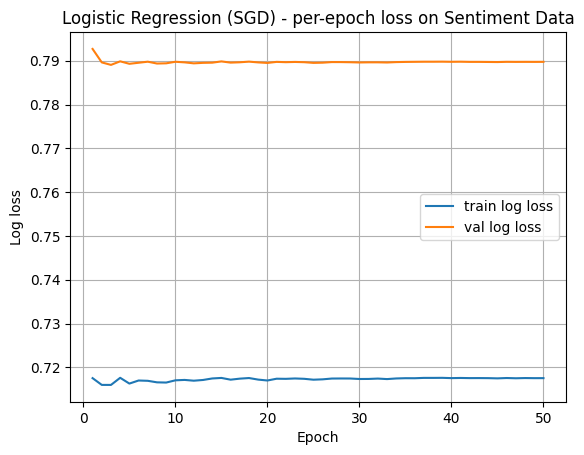

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(tfidf_matrix, df['sentiment'], test_size=0.2, random_state=42)
sentiment_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
y_train_numeric = y_train.map(sentiment_mapping)
y_val_numeric = y_val.map(sentiment_mapping)


clf = SGDClassifier(loss='log_loss', penalty='l2', random_state=0)
classes = np.unique(y_train_numeric)

n_epochs = 50
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    perm = np.random.permutation(X_train.shape[0])
    X_shuf, y_shuf = X_train[perm], y_train_numeric.iloc[perm]
    clf.partial_fit(X_shuf, y_shuf, classes=classes)
    prob_train = clf.predict_proba(X_train)
    prob_val = clf.predict_proba(X_val)

    train_losses.append(log_loss(y_train_numeric, prob_train))
    val_losses.append(log_loss(y_val_numeric, prob_val))
plt.plot(range(1, n_epochs+1), train_losses, label='train log loss')
plt.plot(range(1, n_epochs+1), val_losses, label='val log loss')
plt.xlabel('Epoch')
plt.ylabel('Log loss')
plt.title('Logistic Regression (SGD) - per-epoch loss on Sentiment Data')
plt.legend()
plt.grid(True)
plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


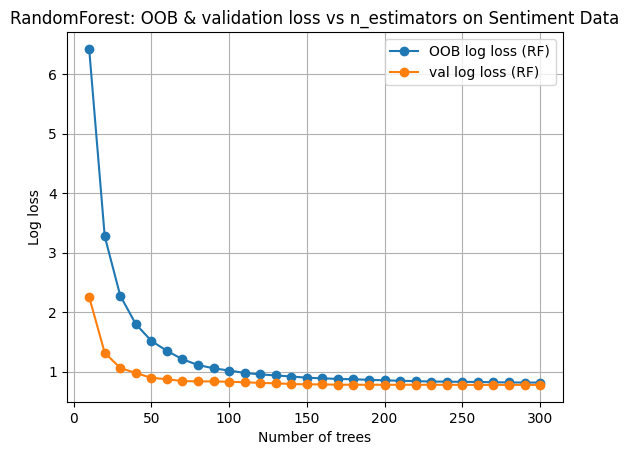

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(tfidf_matrix, df['sentiment'], test_size=0.2, random_state=42)
sentiment_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
y_train_numeric = y_train.map(sentiment_mapping)
y_val_numeric = y_val.map(sentiment_mapping)


rf = RandomForestClassifier(warm_start=True, oob_score=True, bootstrap=True, random_state=0)
n_trees_list = list(range(10, 301, 10))

oob_losses = []
val_losses = []

for n in n_trees_list:
    rf.n_estimators = n
    rf.fit(X_train, y_train_numeric)

    if hasattr(rf, "oob_decision_function_") and rf.oob_decision_function_ is not None:
        oob_prob = rf.oob_decision_function_
        if oob_prob.ndim == 1:
             oob_prob = np.vstack([1 - oob_prob, oob_prob]).T
        if oob_prob.shape[1] == 2 and len(np.unique(y_train_numeric)) == 3:
             oob_prob_full = np.zeros((oob_prob.shape[0], 3))
             if oob_prob.shape[1] == len(rf.classes_):
                 oob_losses.append(log_loss(y_train_numeric, oob_prob, labels=rf.classes_))
             else:
                 oob_losses.append(np.nan)

        elif oob_prob.shape[1] == len(np.unique(y_train_numeric)):
             oob_losses.append(log_loss(y_train_numeric, oob_prob))
        else:
             oob_losses.append(np.nan)

    else:
        oob_losses.append(np.nan)

    val_prob = rf.predict_proba(X_val)
    val_losses.append(log_loss(y_val_numeric, val_prob))


plt.plot(n_trees_list, oob_losses, 'o-', label='OOB log loss (RF)')
plt.plot(n_trees_list, val_losses, 'o-', label='val log loss (RF)')
plt.xlabel('Number of trees')
plt.ylabel('Log loss')
plt.title('RandomForest: OOB & validation loss vs n_estimators on Sentiment Data')
plt.legend()
plt.grid(True)
plt.show()

Accuracy:

In [ ]:
from sklearn.metrics import accuracy_score
y_val_pred_lr = clf.predict(X_val)
accuracy_lr = accuracy_score(y_val_numeric, y_val_pred_lr)
print(f"Logistic Regression Accuracy: {accuracy_lr:.4f}")
y_val_pred_rf = rf.predict(X_val)
accuracy_rf = accuracy_score(y_val_numeric, y_val_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.4f}")

Logistic Regression Accuracy: 0.6718
Random Forest Accuracy: 0.7040


Integrating sentiment analysis results with topic modeling


Top topics with sentiment summary:

Topic 3 (Topic 3), docs=5862, mean_sent=0.033
Top words: im, work, good, go, want, see, get, dont

Topic 1 (Topic 1), docs=5672, mean_sent=-0.029
Top words: miss, like, im, time, dont, haha, love, get

Topic 2 (Topic 2), docs=5394, mean_sent=-0.203
Top words: im, cant, sleep, night, know, sick, sorry, really

Topic 4 (Topic 4), docs=5353, mean_sent=0.287
Top words: day, happy, mother, thanks, mom, thank, love, good

Topic 0 (Topic 0), docs=5199, mean_sent=0.063
Top words: im, morning, going, wish, good, day, star, bored


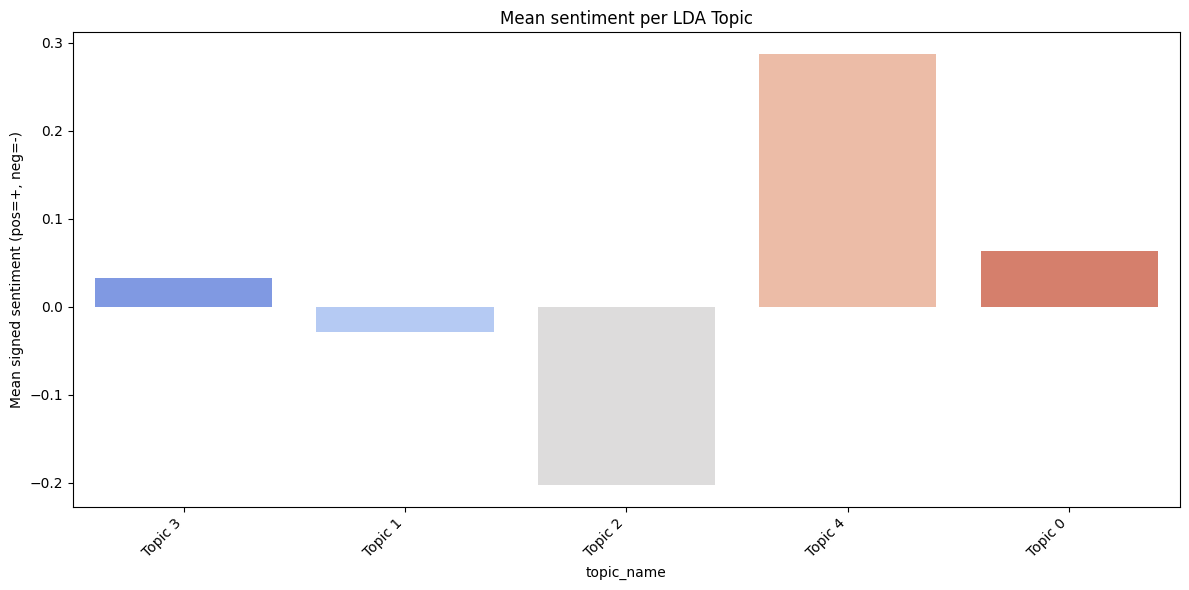

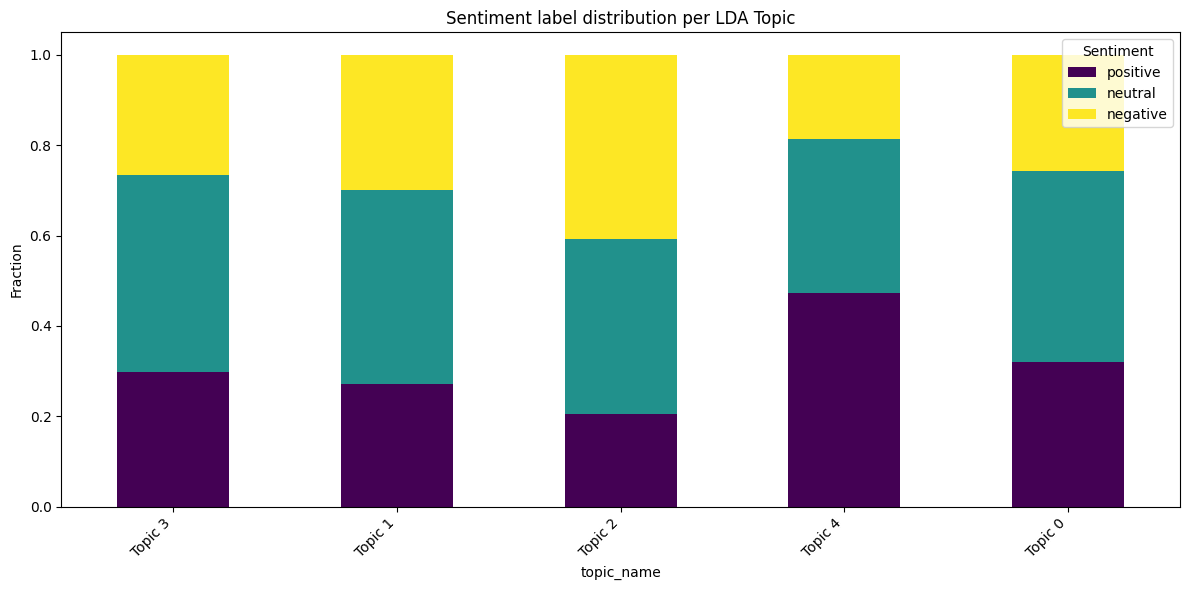


Saved lda_topic_sentiment_summary.csv with topic-level aggregates and top words.

Example docs for Topic 3 sorted by sentiment (top 5 positive):
Sent:1.000 Label:positive --  Yay good for both of you. Enjoy the break - you probably need it after such hectic weekend  Take care hun xxxx...

Sent:1.000 Label:positive -- So I get up early and I feel good about the day. I walk to work and I`m feeling alright. But guess what... I don`t work today....

Sent:1.000 Label:positive -- really really wants to go and see Coraline....

Sent:1.000 Label:positive --  OH SILENCE VERONA!  I AM WANTING TO GO   jaja, enjoyyitverymuch and bring me phothos of Danny and dougie ?...

Sent:1.000 Label:positive -- Glad to see  and more Red Bull Air Racers here keeping us in the loop...



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import warnings
warnings.filterwarnings("ignore")
lda_model = final_lda_model
topic_distributions = lda_model.transform(tfidf_matrix)
topics = np.argmax(topic_distributions, axis=1)
probs = np.max(topic_distributions, axis=1)
sentiments_labels = df['sentiment'].tolist()
sentiment_mapping_signed = {'negative': -1.0, 'neutral': 0.0, 'positive': 1.0}
sentiments_signed = [sentiment_mapping_signed.get(label, 0.0) for label in sentiments_labels]
df_integrated = pd.DataFrame({
    "doc": df['text'].tolist(),
    "topic": topics,
    "probability": probs,
    "sent_label": sentiments_labels,
    "sent_signed": sentiments_signed
})
df_integrated["topic_name"] = df_integrated["topic"].apply(lambda t: f"Topic {t}")
agg = df_integrated.groupby("topic").agg(
    n_docs=("doc", "count"),
    mean_sent_signed=("sent_signed", "mean"),
    median_sent_signed=("sent_signed", "median"),
    pos_fraction=("sent_label", lambda s: (s == "positive").sum() / len(s)),
    neg_fraction=("sent_label", lambda s: (s == "negative").sum() / len(s)),
).reset_index()
agg["topic_name"] = agg["topic"].apply(lambda t: f"Topic {t}")
agg = agg.sort_values("n_docs", ascending=False)
def top_words_for_lda_topic(topic_id, model, vectorizer, top_n=8):
    feature_names = vectorizer.get_feature_names_out()
    topic = model.components_[topic_id]
    top_words_idx = topic.argsort()[-top_n:][::-1]
    top_words = [feature_names[i] for i in top_words_idx]
    return top_words

print("\nTop topics with sentiment summary:")
for _, row in agg.iterrows():
    tid = int(row["topic"])
    if tid < lda_model.n_components:
        print(f"\nTopic {tid} ({row['topic_name']}), docs={row['n_docs']}, mean_sent={row['mean_sent_signed']:.3f}")
        print("Top words:", ", ".join(top_words_for_lda_topic(tid, lda_model, tfidf_vectorizer, top_n=8)))
    else:
        print(f"\nTopic {tid} (Invalid Topic ID), docs={row['n_docs']}, mean_sent={row['mean_sent_signed']:.3f}")

topN = lda_model.n_components
plot_df = agg.head(topN).copy()

plt.figure(figsize=(12, 6))
sns.barplot(data=plot_df, x="topic_name", y="mean_sent_signed", palette="coolwarm")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Mean signed sentiment (pos=+, neg=-)")
plt.title("Mean sentiment per LDA Topic")
plt.tight_layout()
plt.show()
stack_df = df_integrated.groupby(["topic_name", "sent_label"]).size().unstack(fill_value=0)

for sentiment_label in ['negative', 'neutral', 'positive']:
    if sentiment_label not in stack_df.columns:
        stack_df[sentiment_label] = 0
stack_df = stack_df[['positive', 'neutral', 'negative']]
stack_frac = stack_df.loc[plot_df["topic_name"]]
stack_frac = stack_frac.div(stack_frac.sum(axis=1), axis=0).fillna(0)

stack_frac.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="viridis")
plt.ylabel("Fraction")
plt.title("Sentiment label distribution per LDA Topic")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()
agg_out = agg.copy()
agg_out["top_words"] = agg_out["topic"].apply(lambda t: ", ".join(top_words_for_lda_topic(int(t), lda_model, tfidf_vectorizer, top_n=10)))
agg_out.to_csv("lda_topic_sentiment_summary.csv", index=False)
print("\nSaved lda_topic_sentiment_summary.csv with topic-level aggregates and top words.")
most_frequent_topic_id = agg.iloc[0]["topic"]
ex_docs = df_integrated[df_integrated["topic"] == most_frequent_topic_id].sort_values("sent_signed", ascending=False)
print(f"\nExample docs for Topic {most_frequent_topic_id} sorted by sentiment (top 5 positive):")
for i, r in ex_docs.head(5).iterrows():
    print(f"Sent:{r['sent_signed']:.3f} Label:{r['sent_label']} -- {r['doc'][:200].replace('\\n',' ')}...\n")

In [30]:
!pip install wordcloud

Generating word clouds for each topic...


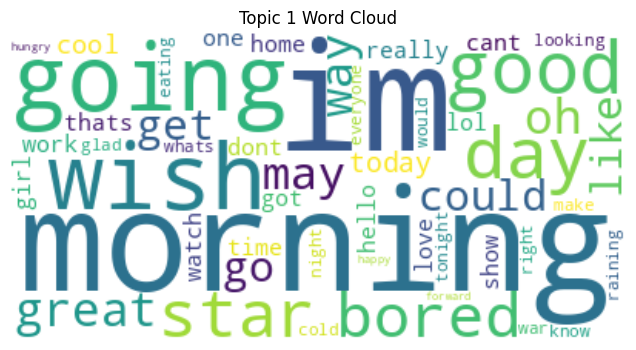

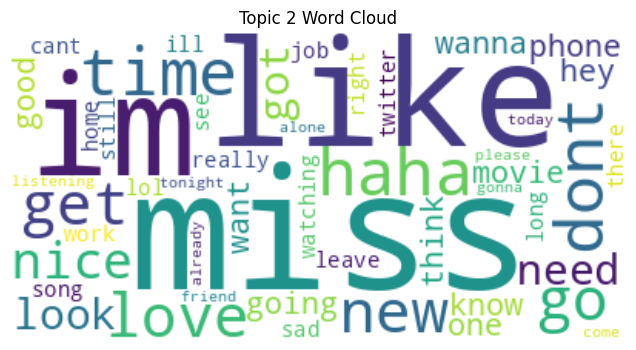

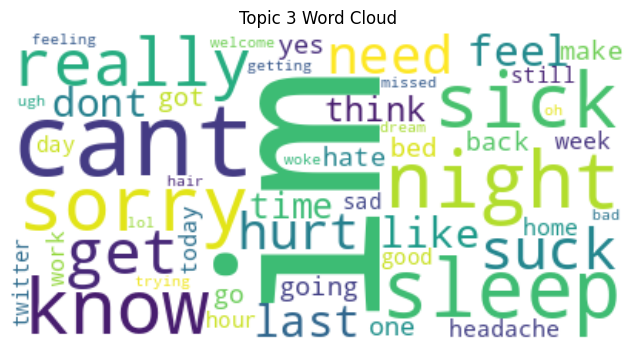

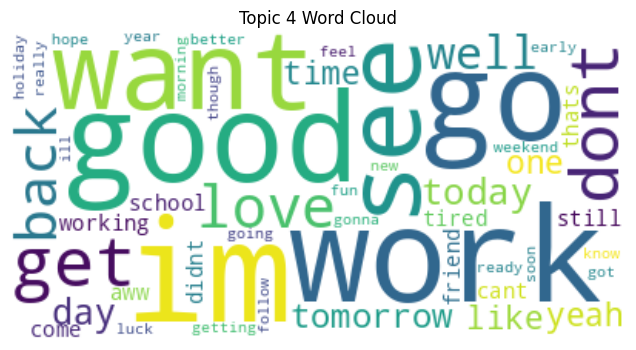

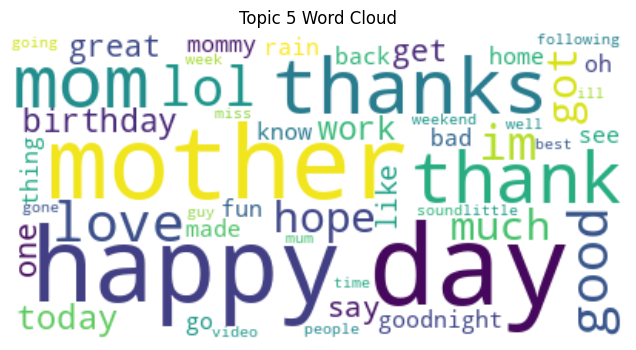

Word cloud generation complete.


In [32]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
feature_names = tfidf_vectorizer.get_feature_names_out()
lda_model = final_lda_model

def create_wordcloud(topic_id, model, vectorizer, top_n=50):
    """Generate a word cloud for a given LDA topic."""
    feature_names = vectorizer.get_feature_names_out()
    topic = model.components_[topic_id]
    top_words_idx = topic.argsort()[-top_n:][::-1]
    top_words = [(feature_names[i], topic[i]) for i in top_words_idx]
    word_freq = dict(top_words)
    wordcloud = WordCloud(width=400, height=200, background_color='white').generate_from_frequencies(word_freq)
    return wordcloud

print("Generating word clouds for each topic...")
for topic_idx in range(lda_model.n_components):
    wc = create_wordcloud(topic_idx, lda_model, tfidf_vectorizer)
    plt.figure(figsize=(8, 4)) # Adjusted figure size
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Topic {topic_idx + 1} Word Cloud")
    plt.show()

print("Word cloud generation complete.")